# Results Analysis Notebook - Senegal CHM

The following notebook is intended to be used for validation of CHM results over Senegal.
The points are taken from GEDI data that has WorldView correspondance.

- one-to-one fitting line for scatterplot
- select region with icesat and gedi data on
- fix variables when there is no icesat data available

In [1]:
import os
import argparse
import h5py
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as rio
import rioxarray as rxr
import matplotlib.pyplot as plt

from rasterio.plot import show, show_hist
from glob import glob
from pathlib import Path
from scipy import ndimage
from scipy.stats import entropy
from skimage.transform import rescale, resize
from shapely.geometry import Point
from shapely.geometry import box
from sklearn import metrics

## Environment Variables

- data_regex: where to find world view data
- chm_regex: where to find CHM world view results
- gedi_regex: where to find GEDI data for validation
- icesat_intersection_regex: where to find intersected ICESAT-2 with WorldView data

In [2]:
# Senegal dataset
data_regex = '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/*M1BS*.tif'
chm_regex = '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2/CAS/*M1BS*.tif'
#chm_regex = '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2.wc/CAS/*M1BS*.tif'
gedi_regex = '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GEDI/CAS/*/*.h5'
icesat_intersection_regex = '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/development/senegal/metadata/intersection/CAS/*.gpkg'

In [3]:
# extract files and store in list
data_filenames = sorted(glob(data_regex))
chm_filenames = sorted(glob(chm_regex))
print(f"{len(data_filenames)} data filenames, {len(chm_filenames)} chm filenames")

712 data filenames, 84 chm filenames


In [4]:
print(chm_filenames)

['/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2/CAS/WV02_20210102_M1BS_10300100B3850700-toa.2m_chm.tif', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2/CAS/WV02_20210102_M1BS_10300100B46F2400-toa.2m_chm.tif', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2/CAS/WV02_20210108_M1BS_10300100B3B0A600-toa.2m_chm.tif', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2/CAS/WV02_20210108_M1BS_10300100B4AED700-toa.2m_chm.tif', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2/CAS/WV02_20210110_M1BS_10300100B143FC00-toa.2m_chm.tif', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2/CAS/WV02_20210110_M1BS_10300100B448B900-toa.2m_chm.tif', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2/CAS/WV02_20210113_M1BS_10300100B0793300-toa.2m_chm.tif', '/explore/nobackup/projects/ilab/

In [25]:
# select data filename
chm_filename = chm_filenames[-3]
chm_filename

'/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1.2/CAS/WV03_20211211_M1BS_10400100707D5C00-toa.2m_chm.tif'

In [26]:
# get corresponding data filename
data_filename = os.path.join(
    Path(data_regex).parent.absolute(),
    f"{Path(Path(chm_filename).stem).stem}.tif"
)

icesat_filename = os.path.join(
    Path(icesat_intersection_regex).parent.absolute(),
    f"{Path(Path(chm_filename).stem).stem}.gpkg"
)

# TODO - get proper gedi dir here
gedi_filenames = glob(os.path.join(
    Path(gedi_regex).parent.absolute().parent.absolute(),
    f"{Path(Path(chm_filename).stem).stem}",
    '*.h5'
))
print(gedi_filenames)

# selected gedi_filename
gedi_filename = gedi_filenames[0]

# read gedi filename and create dataframe
gediL2A = h5py.File(gedi_filename, 'r')

# get full power beam name
beamNames = [g for g in gediL2A.keys() if g.startswith('BEAM')]
beamNames = [b for b in beamNames if gediL2A[b].attrs['description'] == "Full power beam"]
beamName = beamNames[0]

# Set up lists to store data
lonSample, latSample, shotSample, qualitySample, \
    beamSample, rh90 = [], [], [], [], [], []

# Open the SDS
lats = gediL2A[f'{beamName}/lat_lowestmode'][()]
lons = gediL2A[f'{beamName}/lon_lowestmode'][()]
shots = gediL2A[f'{beamName}/shot_number'][()]
quality = gediL2A[f'{beamName}/quality_flag'][()]

# Take every shot and append to list
for i in range(len(shots)):
    #if i % 100 == 0:
    shotSample.append(str(shots[i]))
    lonSample.append(lons[i])
    latSample.append(lats[i])
    qualitySample.append(quality[i])
    beamSample.append(beamName)
    rh90.append(gediL2A['BEAM0101']['rh'][i][89])

# Write all of the sample shots to a dataframe
gedi_gdf = pd.DataFrame({
    'Beam': beamSample, 'Shot Number': shotSample,
     'Longitude': lonSample, 'Latitude': latSample,
    'Quality Flag': qualitySample, 'rh90': rh90
})

del beamSample, quality, qualitySample, latSample, \
    lats, lonSample, lons, shotSample, shots 

# Convert to a Geodataframe
gedi_gdf = gpd.GeoDataFrame(
    gedi_gdf,
    geometry=gpd.points_from_xy(gedi_gdf.Longitude, gedi_gdf.Latitude),
    crs='epsg:4326'
)
gedi_gdf = gedi_gdf.drop(columns=['Latitude', 'Longitude'])
gedi_gdf.head()

['/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GEDI/CAS/WV03_20211211_M1BS_10400100707D5C00-toa/GEDI02_A_2021286173345_O16065_03_T11035_02_003_02_V002.h5', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GEDI/CAS/WV03_20211211_M1BS_10400100707D5C00-toa/GEDI02_A_2021327152256_O16699_02_T02307_02_003_02_V002.h5', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GEDI/CAS/WV03_20211211_M1BS_10400100707D5C00-toa/GEDI02_A_2021331135115_O16760_02_T10539_02_003_02_V002.h5', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GEDI/CAS/WV03_20211211_M1BS_10400100707D5C00-toa/GEDI02_A_2022001234955_O17309_02_T05000_02_003_02_V002.h5', '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GEDI/CAS/WV03_20211211_M1BS_10400100707D5C00-toa/GEDI02_A_2022027233241_O17712_03_T09459_02_003_02_V002.h5']


,Beam,Shot Number,Quality Flag,rh90,geometry
0,BEAM0101,160650500300167385,0,0.0,POINT (-92.29827 51.79493)
1,BEAM0101,160650500300167386,0,0.0,POINT (-92.29745 51.79494)
2,BEAM0101,160650500300167387,0,0.0,POINT (-92.29663 51.79495)
3,BEAM0101,160650500300167388,0,0.0,POINT (-92.29580 51.79496)
4,BEAM0101,160650500300167389,0,0.0,POINT (-92.29498 51.79497)


In [27]:
gedi_gdf = gedi_gdf.set_crs('epsg:4326')
gedi_gdf = gedi_gdf.to_crs('epsg:32628')
gedi_gdf['geometry']
gedi_gdf.crs

<Derived Projected CRS: EPSG:32628>
Name: WGS 84 / UTM zone 28N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°W and 12°W, northern hemisphere between equator and 84°N, onshore and offshore. Gambia. Greenland. Guinea. Guinea-Bissau. Iceland. Ireland - offshore Porcupine Basin. Mauritania. Morocco. Senegal. Sierra Leone. Western Sahara.
- bounds: (-18.0, 0.0, -12.0, 84.0)
Coordinate Operation:
- name: UTM zone 28N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

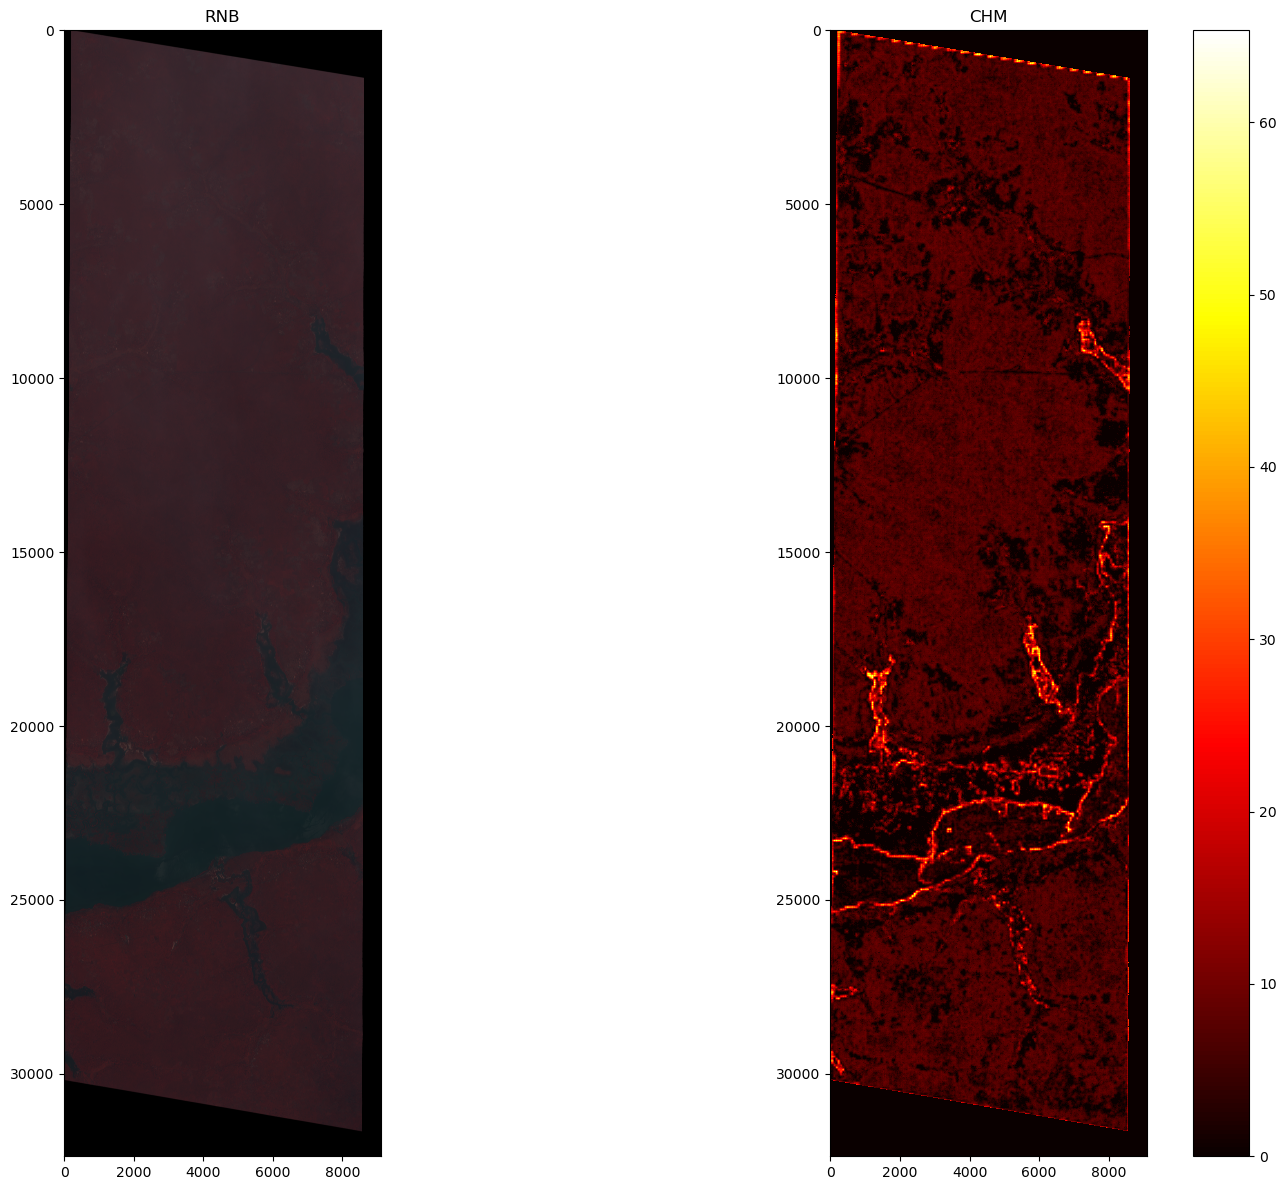

In [28]:
# open filenames
src_data = rio.open(data_filename)
src_chm_metadata = rio.open(chm_filename)
src_chm = src_chm_metadata.read()

# clean some of the chm values for visualization
src_chm[src_chm < 1] = 0
src_chm[src_chm >= 255] = 0

# clean some of the data for visualization
src_data_clean = src_data.read((7,3,2))
src_data_clean[src_data_clean < 0] = 0


fig, axs = plt.subplots(1, 2, figsize=(16,12))

# rgb image
show(src_data_clean / 10000.0, ax=axs[0])
axs[0].set_title("RNB")

# chm image
im = axs[1].imshow(np.squeeze(src_chm), cmap='hot', interpolation='nearest')
axs[1].set_title("CHM")
plt.colorbar(im, ax=axs[1])


"""
# rgb histogram
show_hist(
    src_data, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', ax=axs[0, 1])
axs[1, 0].legend(["CB", "B", "G", "Y", "R", "RE", "N", "N2"],loc="upper right")

# chm histogram
src_chm = np.squeeze(src_chm).flatten()
#src_chm[src_chm < 1] = 0
src_chm[src_chm < 0] = 0
src_chm[src_chm > 255] = 0
src_chm = np.delete(src_chm, np.where(src_chm == 0))
src_chm = np.delete(src_chm, np.where(src_chm == 255))

axs[1, 1].hist(np.squeeze(src_chm), 50, density=True, facecolor='g', alpha=0.75)
axs[1, 1].set_xlabel('CHM (m)')
axs[1, 1].set_ylabel('Probability')
axs[1, 1].set_title('Histogram of CHM Values')
"""

fig.tight_layout()
plt.show()

In [29]:
# TODO: Really nice plot would be a folium map with the raster, and a marker on top of the
# GEDI observation with the CHM value and the GEDI RH90 value

In [30]:
# world view extent
extent=box(*src_chm_metadata.bounds)

# clip gedi to world view extent
gedi_gdf_clipped = gpd.clip(gedi_gdf, extent)        
coord_list = [(x,y) for x,y in zip(gedi_gdf_clipped['geometry'].x , gedi_gdf_clipped['geometry'].y)]
gedi_gdf_clipped['wv_chm'] = [float(x) for x in src_chm_metadata.sample(coord_list)]

# filter no-data from gedi and world view, round to the second position
gedi_gdf_clipped = gedi_gdf_clipped[gedi_gdf_clipped.wv_chm != 255]
#gedi_gdf_clipped['wv_chm'] = gedi_gdf_clipped['wv_chm'].round(2)
#gedi_gdf_clipped['rh90'] = gedi_gdf_clipped['rh90'].round(2)
gedi_gdf_clipped = gedi_gdf_clipped.round(2)

# get icesat with worldview
icesat_gdf = gpd.read_file(icesat_filename)
coord_list = [(x,y) for x,y in zip(icesat_gdf['geometry'].x , icesat_gdf['geometry'].y)]
icesat_gdf['wv_chm'] = [float(x) for x in src_chm_metadata.sample(coord_list)]
print("ICESAT Observations without no-data filtered: ", icesat_gdf.shape)

# filter icesat only of there are some world view observations
icesat_gdf_filtered = icesat_gdf[icesat_gdf.wv_chm != 255]
icesat_status = '(match with WorldView)'
if icesat_gdf_filtered.shape[0] == 0:
    icesat_gdf_filtered = icesat_gdf
    icesat_status = '(no match with WorldView)'

icesat_gdf_filtered.wv_chm = icesat_gdf_filtered.wv_chm.round(2)
icesat_gdf_filtered.h_can_20m = icesat_gdf_filtered.h_can_20m.round(2)

# get size before and after filtering
print("GEDI - Before extent clip: ", gedi_gdf.shape, "After extent clip: ", gedi_gdf_clipped.shape)
print("ICESAT Observations after no-data filtered: ", icesat_gdf_filtered.shape)

ICESAT Observations without no-data filtered:  (0, 28)
GEDI - Before extent clip:  (95712, 5) After extent clip:  (203, 6)
ICESAT Observations after no-data filtered:  (0, 28)


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [31]:
gedi, wv = [], []
gedi_gdf_clipped =  gedi_gdf_clipped.loc[gedi_gdf_clipped["wv_chm"] > 0]

for _, row in gedi_gdf_clipped.iterrows():
    #print(round(row['rh90'], 2), row['wv_chm'])
    if abs(round(row['rh90'], 2) - row['wv_chm']) <= 4:
        gedi.append(round(row['rh90'], 2))
        wv.append(row['wv_chm'])
print(len(gedi))


gedi_gdf_clipped = pd.DataFrame({'rh90': gedi, 'wv_chm_fixed': wv})
#df['new'] = np.where((df['Column1'] <= df['Column2']) & (
#    df['Column1'] <= df['Column3']), df['Column1'], np.nan)

121


In [32]:
gedi_gdf_clipped.to_csv('observation3.csv')

In [34]:
ll = []
for a in range(1,4):
    ll.append(pd.read_csv(f'observation{str(a)}.csv'))

gedi_gdf_clipped = pd.concat(ll)
gedi_gdf_clipped.shape

(320, 3)

0.44 11.16 0.07 9.49


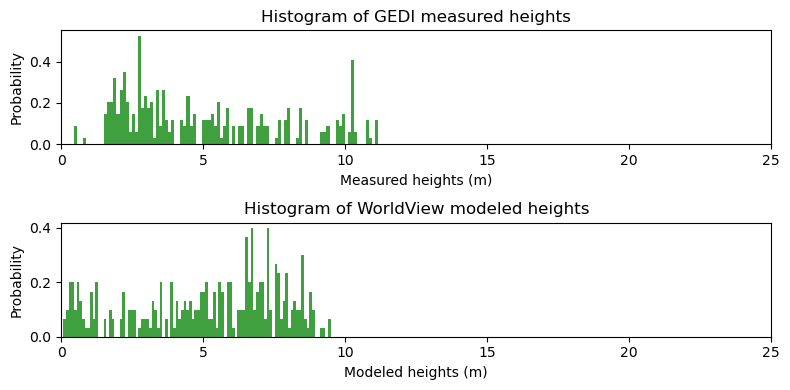

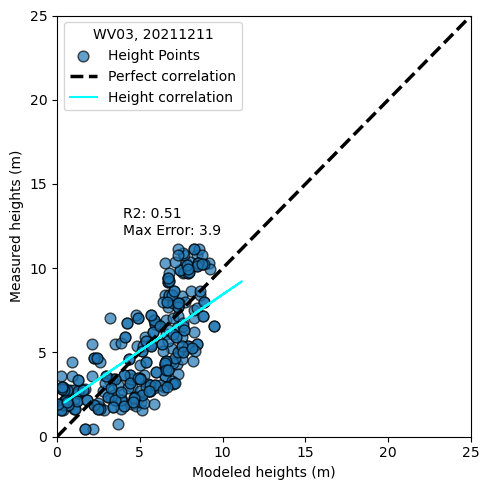

R^2:  0.5121033900475289 
MAE:  1.7431875 
MSE:  3.9489999999999994 
Max Error:  3.9000000000000004


In [35]:

# set values into a numpy array for visualization
gedi_rh90 = gedi_gdf_clipped.rh90.values
#gedi_world_view = gedi_gdf_clipped.wv_chm.values

#gedi_gdf_clipped['wv_chm_fixed'] = [x + 1 if x > 4 else x for x in gedi_gdf_clipped['wv_chm_fixed']]
gedi_world_view = gedi_gdf_clipped.wv_chm_fixed.values

print(gedi_rh90.min(), gedi_rh90.max(), gedi_world_view.min(), gedi_world_view.max())

# set values into a numpy array for visualization
icesat_h_can_20m = icesat_gdf_filtered.h_can_20m.values
icesat_world_view = icesat_gdf_filtered.wv_chm.values

fig, axs = plt.subplots(2, 1, figsize=(8,4))

axs[0].hist(gedi_rh90, 100, density=True, facecolor='g', alpha=0.75)
axs[0].set_xlabel('Measured heights (m)')
axs[0].set_ylabel('Probability')
axs[0].set_xlim((0, 25))
axs[0].set_title('Histogram of GEDI measured heights')

axs[1].hist(gedi_world_view, 100, density=True, facecolor='g', alpha=0.75)
axs[1].set_xlabel('Modeled heights (m)')
axs[1].set_ylabel('Probability')
axs[1].set_xlim((0, 25))
axs[1].set_title('Histogram of WorldView modeled heights')

#axs[2].hist(icesat_h_can_20m, 100, density=True, facecolor='g', alpha=0.75)
#axs[2].set_xlabel('CHM (m)')
#axs[2].set_ylabel('Probability')
#axs[2].set_xlim((0, 25))
#axs[2].set_title(f'Histogram of ICESAT-2 h_can_20m Values {icesat_status}')

fig.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize = (5, 5))

# Fit linear regression via least squares with numpy.polyfit
#b, a = np.polyfit(gedi_world_view, gedi_rh90, deg=1)
b, a = np.polyfit(gedi_rh90, gedi_rh90, deg=1)
xseq = np.linspace(0, 25, num=400)  # create a sequence

ax.scatter(gedi_world_view, gedi_rh90, s=60, alpha=0.7, edgecolors="k", label="Height Points")
ax.plot(xseq, a + b * xseq, color="k", lw=2.5, linestyle='dashed', label="Perfect correlation");
ax.set_xlabel('Modeled heights (m)')
ax.set_ylabel('Measured heights (m)')
#ax.set_title('Scatter plot of GEDI vs WorldView CHM Values')
ax.set_xlim((0, 25))
ax.set_ylim((0, 25))

# linear regression line
m, b = np.polyfit(gedi_rh90, gedi_world_view, 1)
ax.plot(gedi_rh90, m * gedi_rh90 + b, color="cyan", label="Height correlation")

g_filename = Path(chm_filename).stem.split('_')
ax.legend(title=f'{g_filename[0]}, {g_filename[1]}', loc='upper left')

# R2 score inside plot
ax.annotate(
    'R2: ' + str(round(metrics.r2_score(gedi_rh90, gedi_world_view), 2)),
    xy = (4, 13)
)
ax.annotate(
    'Max Error: ' + str(round(metrics.max_error(gedi_rh90, gedi_world_view), 2)),
    xy = (4, 12)
)
    
#ax.scatter(temp_df['Depth_m'], temp_df[f'Pred_Depth_m_{str(year)}'], label="Depth points")
#ax.errorbar(temp_df['Depth_m'], temp_df[f'Pred_Depth_m_{str(year)}'], yerr=temp_df[f'RMSE_{str(year)}'], fmt="o")
#ax.set(xlabel='Measured depth (m)', ylabel='Modeled depth (m)')
#ax.set_xlim((0, 25))
#ax.set_ylim((0, 25))


fig.tight_layout()
plt.show()

print(
    "R^2: ", metrics.r2_score(gedi_rh90, gedi_world_view),
    "\nMAE: ", metrics.mean_absolute_error(gedi_rh90, gedi_world_view),
    "\nMSE: ", metrics.mean_squared_error(gedi_rh90, gedi_world_view),
    "\nMax Error: ", metrics.max_error(gedi_rh90, gedi_world_view)
)